In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root added to path: {project_root}")
print(f"Current working directory: {Path.cwd()}")

Project root added to path: /home/mohamed-ashraf/Desktop/projects/Arabic-Diacritization
Current working directory: /home/mohamed-ashraf/Desktop/projects/Arabic-Diacritization/models/bilstm2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from utils.utils import create_data_pipeline
from models.bilstm2.bilstm2 import BiLSTM

2025-12-04 17:18:43.633764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 17:18:43.670816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 17:18:44.671245: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
with open(project_root / "utils/letter2idx.pickle", "rb") as file:
    letter2idx = pickle.load(file)

with open(project_root / "utils/diacritic2id.pickle", "rb") as file:
    diacritic2id = pickle.load(file)

idx2letter = {value: key for key, value in letter2idx.items()}
idx2diacritic = {value: key for key, value in diacritic2id.items()}

print(letter2idx)
print(idx2letter)
print(diacritic2id)
print(idx2diacritic)

{'ظ': 0, 'ي': 1, 'غ': 2, 'ن': 3, 'ق': 4, 'ذ': 5, 'د': 6, 'خ': 7, 'ر': 8, 'ط': 9, 'ى': 10, 'م': 11, 'ل': 12, '<PAD>': 13, 'ت': 14, 'ج': 15, 'آ': 16, 'ا': 17, 'س': 18, 'ئ': 19, 'ع': 20, 'ف': 21, 'ص': 22, 'ه': 23, 'ز': 24, 'ك': 25, 'ش': 26, 'أ': 27, 'و': 28, 'ب': 29, 'ؤ': 30, 'ض': 31, 'ة': 32, 'ث': 33, 'ء': 34, 'ح': 35, 'إ': 36, ' ': 37}
{0: 'ظ', 1: 'ي', 2: 'غ', 3: 'ن', 4: 'ق', 5: 'ذ', 6: 'د', 7: 'خ', 8: 'ر', 9: 'ط', 10: 'ى', 11: 'م', 12: 'ل', 13: '<PAD>', 14: 'ت', 15: 'ج', 16: 'آ', 17: 'ا', 18: 'س', 19: 'ئ', 20: 'ع', 21: 'ف', 22: 'ص', 23: 'ه', 24: 'ز', 25: 'ك', 26: 'ش', 27: 'أ', 28: 'و', 29: 'ب', 30: 'ؤ', 31: 'ض', 32: 'ة', 33: 'ث', 34: 'ء', 35: 'ح', 36: 'إ', 37: ' '}
{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13, '': 14, '<PAD>': 15}
{0: 'َ', 1: 'ً', 2: 'ُ', 3: 'ٌ', 4: 'ِ', 5: 'ٍ', 6: 'ْ', 7: 'ّ', 8: 'َّ', 9: 'ًّ', 10: 'ُّ', 11: 'ٌّ', 12: 'ِّ', 13: 'ٍّ', 14: '', 15: '<PAD>'}


In [5]:
vocab_size = len(letter2idx) 
num_classes = len(diacritic2id)
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 38
Num classes: 16


In [6]:
def train_model_dynamic(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=diacritic2id['<PAD>'])
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_path = 'best_dynamic_blstm_model.pth'
    
    for epoch in range(epochs):
        model.train()

        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_X, batch_y, _, lengths in pbar:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()

                outputs = model(batch_X, lengths)

                B, T, C = outputs.shape
                loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                preds = outputs.argmax(dim=-1)
                mask = (batch_y != diacritic2id['<PAD>'])

                correct = (preds[mask] == batch_y[mask]).sum().item()
                total = mask.sum().item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                total_train_correct += correct
                total_train_tokens += total

                acc = correct / total if total > 0 else 0.0

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{acc:.4f}'
                })

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / total_train_tokens

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]') as pbar:
                for batch_X, batch_y, _, lengths in pbar:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    outputs = model(batch_X, lengths)
                    B, T, C = outputs.shape

                    loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                    preds = outputs.argmax(dim=-1)
                    mask = (batch_y != diacritic2id['<PAD>'])

                    correct = (preds[mask] == batch_y[mask]).sum().item()
                    total = mask.sum().item()

                    total_val_loss += loss.item()
                    total_val_correct += correct
                    total_val_tokens += total

                    acc = correct / total if total > 0 else 0.0

                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{acc:.4f}'
                    })

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_correct / total_val_tokens

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'val_accuracy': avg_val_acc,
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_acc
            }, best_model_path)
            print(f"  ↳ Best model saved! (val_loss: {best_val_loss:.4f})")

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }

In [7]:
def pad_collate_fn(batch):
    x_batch, y_batch, mask_batch = zip(*batch)
    lengths_x = [len(x) for x in x_batch]
    x_padded = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=letter2idx['<PAD>'])
    y_padded = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=diacritic2id['<PAD>'])
    mask_spadded = torch.nn.utils.rnn.pad_sequence(mask_batch, batch_first=True, padding_value=0)
    return x_padded, y_padded, mask_spadded, torch.tensor(lengths_x, dtype=torch.long)

In [9]:
train_dataset, train_loader = create_data_pipeline(
    corpus_path=str(project_root / 'data/train.txt'), 
    letter2idx=letter2idx, 
    diacritic2idx=diacritic2id, 
    collate_fn=pad_collate_fn,
    batch_size=32
)

val_dataset, val_loader = create_data_pipeline(
    corpus_path=str(project_root / 'data/val.txt'), 
    letter2idx=letter2idx, 
    diacritic2idx=diacritic2id,
    collate_fn=pad_collate_fn,
    train=False, 
    batch_size=32
)

In [10]:
model = BiLSTM(vocab_size=vocab_size, num_classes=num_classes).to(device)

print("Model architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
BiLSTM(
  (embedding): Embedding(38, 256, padding_idx=13)
  (bilstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (emb_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lstm_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=512, out_features=16, bias=True)
)

Total parameters: 2,649,104
Trainable parameters: 2,649,104


\nModel Summary:
Total parameters: 2,649,104
\nStarting training with dynamic sequence lengths...


Epoch 1/10 [Val]: 100%|██████████| 281/281 [00:03<00:00, 91.43it/s, Loss=0.1072, Acc=0.9734] 


  ↳ Best model saved! (val_loss: 0.0953)
Epoch 1/10:
  Train Loss: 0.1510, Train Acc: 0.9491
  Val Loss: 0.0953, Val Acc: 0.9688
  LR: 0.001000


Epoch 2/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 106.27it/s, Loss=0.0562, Acc=0.9783]


  ↳ Best model saved! (val_loss: 0.0809)
Epoch 2/10:
  Train Loss: 0.0917, Train Acc: 0.9695
  Val Loss: 0.0809, Val Acc: 0.9736
  LR: 0.001000


Epoch 3/10 [Val]: 100%|██████████| 281/281 [00:03<00:00, 90.76it/s, Loss=0.0734, Acc=0.9734]


  ↳ Best model saved! (val_loss: 0.0764)
Epoch 3/10:
  Train Loss: 0.0799, Train Acc: 0.9733
  Val Loss: 0.0764, Val Acc: 0.9752
  LR: 0.001000


Epoch 4/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 100.47it/s, Loss=0.0433, Acc=0.9831]


  ↳ Best model saved! (val_loss: 0.0726)
Epoch 4/10:
  Train Loss: 0.0731, Train Acc: 0.9755
  Val Loss: 0.0726, Val Acc: 0.9765
  LR: 0.001000


Epoch 5/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 99.65it/s, Loss=0.0625, Acc=0.9783] 


  ↳ Best model saved! (val_loss: 0.0712)
Epoch 5/10:
  Train Loss: 0.0689, Train Acc: 0.9769
  Val Loss: 0.0712, Val Acc: 0.9772
  LR: 0.001000


Epoch 6/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 95.57it/s, Loss=0.0579, Acc=0.9807] 


  ↳ Best model saved! (val_loss: 0.0695)
Epoch 6/10:
  Train Loss: 0.0655, Train Acc: 0.9780
  Val Loss: 0.0695, Val Acc: 0.9779
  LR: 0.001000


Epoch 7/10 [Val]: 100%|██████████| 281/281 [00:03<00:00, 91.69it/s, Loss=0.0641, Acc=0.9807] 


  ↳ Best model saved! (val_loss: 0.0689)
Epoch 7/10:
  Train Loss: 0.0631, Train Acc: 0.9787
  Val Loss: 0.0689, Val Acc: 0.9780
  LR: 0.001000


Epoch 8/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 95.87it/s, Loss=0.0527, Acc=0.9783] 


Epoch 8/10:
  Train Loss: 0.0609, Train Acc: 0.9794
  Val Loss: 0.0695, Val Acc: 0.9780
  LR: 0.001000


Epoch 9/10 [Val]: 100%|██████████| 281/281 [00:03<00:00, 88.05it/s, Loss=0.0432, Acc=0.9831] 


  ↳ Best model saved! (val_loss: 0.0679)
Epoch 9/10:
  Train Loss: 0.0593, Train Acc: 0.9800
  Val Loss: 0.0679, Val Acc: 0.9785
  LR: 0.001000


Epoch 10/10 [Val]: 100%|██████████| 281/281 [00:02<00:00, 96.51it/s, Loss=0.0337, Acc=0.9855] 


Epoch 10/10:
  Train Loss: 0.0579, Train Acc: 0.9804
  Val Loss: 0.0690, Val Acc: 0.9784
  LR: 0.001000


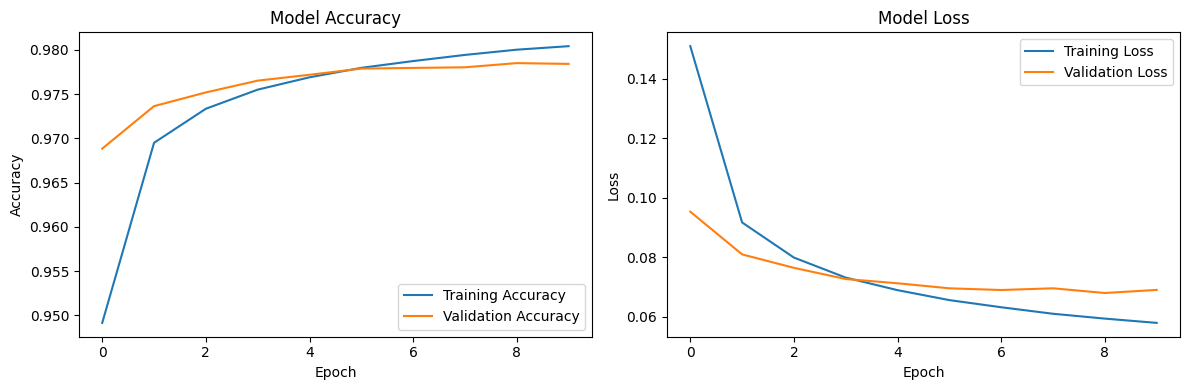

Model saved successfully as 'dynamic_blstm_model.pth'!


In [11]:
# Print model summary
print("\\nModel Summary:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model with dynamic sequences
print("\\nStarting training with dynamic sequence lengths...")
history = train_model_dynamic(model, train_loader, val_loader, epochs=10)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'history': history
}, 'dynamic_blstm_model.pth')

print("Model saved successfully as 'dynamic_blstm_model.pth'!")